In [2]:
import os
import cv2
import torch
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog
from torchvision.models import resnet50
import torchvision.transforms as transforms
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import PIL


In [3]:
# Define the paths to your flooded and non-flooded image folders
flooded_image_folder = 'dataset/flooded/'
non_flooded_image_folder = 'dataset/non-flooded/'

## Per Pixel Classification

#### 1- using k-mean clustering

In [5]:
def per_pixel_classification_kmeans(image_path, num_clusters):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape the image into a 2D array of pixels
    pixels = image_rgb.reshape(-1, 3)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get the cluster labels for each pixel
    labels = kmeans.labels_
    
    # Reshape the labels back into the original image shape
    clustered_image = labels.reshape(image.shape[:2])
    
    # Convert the cluster labels to colors for visualization
    cluster_colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue
    colors = cluster_colors[clustered_image]
    
    # Create a new image with the cluster colors
    clustered_image_rgb = colors.astype(np.uint8)
    image = cv2.resize(image, (512, 512))
    clustered_image_rgb = cv2.resize(clustered_image_rgb, (512, 512))
    
    # Plot the original and segmented images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(clustered_image_rgb)
    axes[1].set_title('Segmented Image (K-MEAN)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


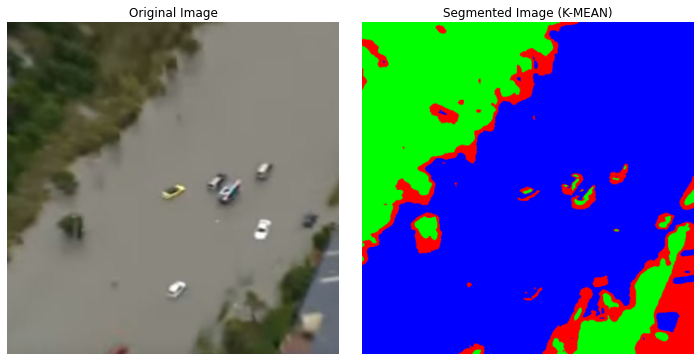

In [8]:
image_path = 'dataset/flooded/417.jpg'
per_pixel_classification_kmeans(image_path,3)

#### 2- using GMM

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from PIL import Image


def gmm_clustering(image_path, n_components):
    # Load the image
    image = Image.open(image_path)
    image_array = np.array(image)

    # Reshape the image to a 2D array of pixels
    pixels = image_array.reshape(-1, 3)

    # Perform GMM clustering
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pixels)
    cluster_assignments = gmm.predict(pixels)
    cluster_centers = gmm.means_.astype(int)

    # Choose distinct colors for clusters
    cluster_colors = np.array([
        [255, 0, 0],    # Red
        [0, 255, 0],    # Green
        [0, 0, 255],    # Blue
        [255, 255, 0],  # Yellow
        [255, 0, 255],  # Magenta
        [0, 255, 255]   # Cyan
    ])

    # Create segmented image
    segmented_image = cluster_colors[cluster_assignments].reshape(image_array.shape)

    # Plot the original and segmented images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(segmented_image)
    axes[1].set_title('Segmented Image (GMM)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



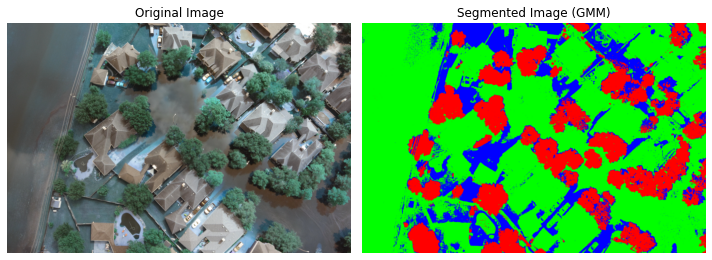

In [248]:
# Example usage
image_path = 'dataset/flooded/1.jpg'
n_components = 3  # Number of clusters/components
gmm_clustering(image_path, n_components)

# 1-Preprocessing Data

In [165]:
# Function to read and preprocess the images
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Apply preprocessing steps
    # For example, you can resize the image to a specific size (e.g., 256x256)
    resized_image = cv2.resize(image, (256, 256))
    
    # You can apply additional preprocessing steps here, such as noise removal, image enhancement, etc.
    
    # Normalize the pixel values to a specific range (e.g., 0-1)
    normalized_image = resized_image.astype(np.float32) / 255.0
    
    return normalized_image

In [166]:
# Read and preprocess the flooded images
flooded_images = []
for image_file in os.listdir(flooded_image_folder):
    image_path = os.path.join(flooded_image_folder, image_file)
    preprocessed_image = preprocess_image(image_path)
    flooded_images.append(preprocessed_image)

In [167]:
# Read and preprocess the non-flooded images
non_flooded_images = []
for image_file in os.listdir(non_flooded_image_folder):
    image_path = os.path.join(non_flooded_image_folder, image_file)
    preprocessed_image = preprocess_image(image_path)
    non_flooded_images.append(preprocessed_image)

In [168]:
# Convert the image lists to NumPy arrays
flooded_images = np.array(flooded_images)
non_flooded_images = np.array(non_flooded_images)

In [169]:
# Print the shapes of the preprocessed image arrays
print("Shape of flooded images array:", flooded_images.shape)
print("Shape of non-flooded images array:", non_flooded_images.shape)

Shape of flooded images array: (461, 256, 256, 3)
Shape of non-flooded images array: (461, 256, 256, 3)


## Deep Learning Technique

In [170]:
# Create labels for the images
flooded_labels = np.ones(len(flooded_images))
non_flooded_labels = np.zeros(len(non_flooded_images))

# Concatenate the images and labels
images = np.concatenate((flooded_images, non_flooded_images))
labels = np.concatenate((flooded_labels, non_flooded_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert the arrays to PyTorch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [171]:
class FloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # if self.transform:
        #     image = self.transform(image)
        image = torch.reshape(image,(3,256,256))
        return image, label


In [172]:

# Define the transformations to apply to the images
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create the datasets and data loaders
train_dataset = FloodDataset(X_train, y_train, transform=transform)
test_dataset = FloodDataset(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [173]:
# Define the neural network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3,stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64,1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [174]:
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(os.path.exists("\best_model.pt")):
    model.load_state_dict(torch.load("best_model.pt"))

model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss combines sigmoid and binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 50

best_accuracy = 0.0  # Track the best accuracy on the test set

In [175]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Evaluate the model on the test set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted_labels = torch.sigmoid(outputs).round().squeeze()
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

    # Check if the current model has better accuracy than the previous best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pt")  # Save the best model

print("Training complete.")


Epoch 1/50, Loss: 0.6918
Accuracy: 0.6757, Precision: 0.6462, Recall: 0.8571, F1 score: 0.7368
Epoch 2/50, Loss: 0.6618
Accuracy: 0.6811, Precision: 0.6403, Recall: 0.9082, F1 score: 0.7511
Epoch 3/50, Loss: 0.6402
Accuracy: 0.6757, Precision: 0.6397, Recall: 0.8878, F1 score: 0.7436
Epoch 4/50, Loss: 0.6329
Accuracy: 0.6703, Precision: 0.6331, Recall: 0.8980, F1 score: 0.7426
Epoch 5/50, Loss: 0.6163
Accuracy: 0.6595, Precision: 0.6400, Recall: 0.8163, F1 score: 0.7175
Epoch 6/50, Loss: 0.6030
Accuracy: 0.6757, Precision: 0.6727, Recall: 0.7551, F1 score: 0.7115
Epoch 7/50, Loss: 0.5913
Accuracy: 0.5351, Precision: 1.0000, Recall: 0.1224, F1 score: 0.2182
Epoch 8/50, Loss: 0.6056
Accuracy: 0.6919, Precision: 0.6990, Recall: 0.7347, F1 score: 0.7164
Epoch 9/50, Loss: 0.5805
Accuracy: 0.6703, Precision: 0.6457, Recall: 0.8367, F1 score: 0.7289
Epoch 10/50, Loss: 0.6000
Accuracy: 0.6703, Precision: 0.6331, Recall: 0.8980, F1 score: 0.7426
Epoch 11/50, Loss: 0.5699
Accuracy: 0.7135, Preci

In [176]:
print("Best Model Accuracy = ",best_accuracy*100 ,  "%")

Best Model Accuracy =  81.62162162162161 %


##### Images after preprocessing

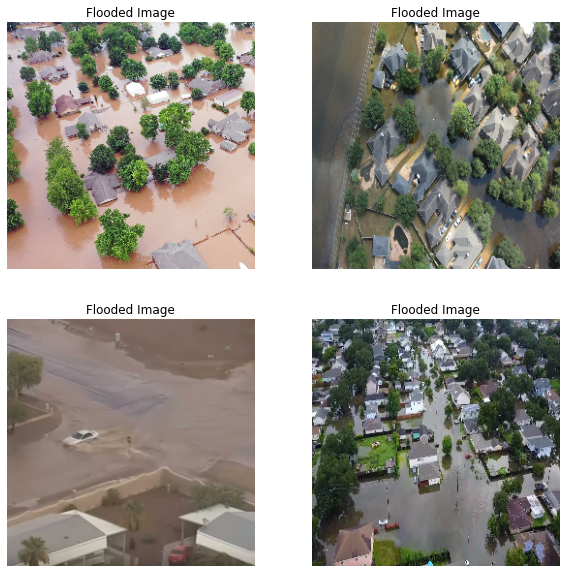

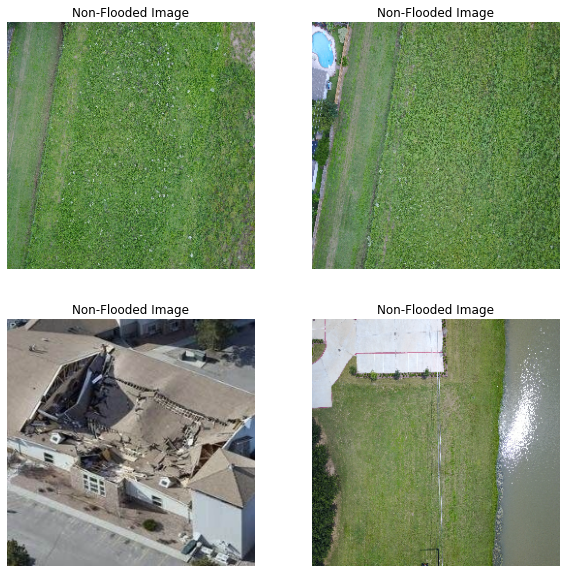

In [177]:
#show 4 images in flooded_images and non_flooded_images after preprocessing
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(flooded_images[i])
    plt.title('Flooded Image')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(non_flooded_images[i])
    plt.title('Non-Flooded Image')
    plt.axis('off')
plt.show()


# 2- Feature Extraction

#### LBP Feature Extraction Function

In [178]:
# Function to extract features using Local Binary Patterns (LBP)
def extract_lbp_features(image):
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute LBP features
    lbp = local_binary_pattern(grayscale_image, 8, 1, method='uniform')
    histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    normalized_histogram = histogram.astype(np.float32) / np.sum(histogram)
    
    return normalized_histogram

#### CNN Feature Extraction Function

In [179]:
def extract_cnn_features(image):
    # Preprocess the image for ResNet-50
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Convert the image to uint8 data type
    image = (image * 255).astype(np.uint8)
    
    # Apply the transformations
    preprocessed_image = transform(image)
    
    # Load the pre-trained ResNet-50 model
    model = resnet50(pretrained=True)
    
    # Remove the last fully connected layer from the model
    features_model = torch.nn.Sequential(*list(model.children())[:-1])
    
    # Set the model to evaluation mode
    features_model.eval()
    
    # Extract features from the preprocessed image
    # preprocessed_image.unsqueeze(0) is used to add a batch dimension to the tensor before passing it to the model.
    # with torch.no_grad() is used to disable gradient computation, saving memory and speeding up the process.
    with torch.no_grad():
        features = features_model(preprocessed_image.unsqueeze(0))
    
    # Flatten the features
    flattened_features = features.view(features.size(0), -1).numpy()
    
    return flattened_features

#### HOG Feature Extraction Function

In [180]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(grayscale_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return hog_features

#### GLCM Feature Extraction Function

In [181]:
def extract_glcm_features(image):
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the GLCM
    glcm = greycomatrix(grayscale_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract desired GLCM properties
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]

    # Return the extracted GLCM features as a list or array
    glcm_features = [contrast, dissimilarity, homogeneity, energy, correlation]
    return glcm_features


In [182]:
# Function to convert image to unsigned integer type
def convert_to_uint(image):
    return (image * 255).astype(np.uint8)

In [183]:
# Apply feature extraction methods to the flooded images
flooded_cnn_features = []
flooded_lbp_features = []
flooded_hog_features = []
flooded_glcm_features = []

#### Extracting all features for flooded images

In [184]:
for image in flooded_images:
    flooded_cnn_features.append(extract_cnn_features(image))
    flooded_lbp_features.append(extract_lbp_features(image))
    flooded_hog_features.append(extract_hog_features(image))
    uint_image = convert_to_uint(preprocessed_image)
    flooded_glcm_features.append(extract_glcm_features(uint_image))


# Convert the feature lists to NumPy arrays
flooded_cnn_features = np.array(flooded_cnn_features)
flooded_lbp_features = np.array(flooded_lbp_features)
flooded_hog_features = np.array(flooded_hog_features)
flooded_glcm_features = np.array(flooded_glcm_features)



# Print the shapes of the feature arrays
print("Shape of flooded CNN features array:", flooded_cnn_features.shape)
print("Shape of flooded LBP features array:", flooded_lbp_features.shape)
print("Shape of flooded HOG features array:", flooded_hog_features.shape)
print("Shape of flooded GLCM features array:", flooded_glcm_features.shape)



c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shape of flooded CNN features array: (461, 1, 2048)
Shape of flooded LBP features array: (461, 9)
Shape of flooded HOG features array: (461, 34596)
Shape of flooded GLCM features array: (461, 5)


In [185]:
# Apply feature extraction methods to the non-flooded images
non_flooded_cnn_features = []
non_flooded_lbp_features = []
non_flooded_hog_features = []
non_flooded_glcm_features = []

#### Extracting all features for flooded images

In [186]:
for image in non_flooded_images:
    non_flooded_cnn_features.append(extract_cnn_features(image))
    non_flooded_lbp_features.append(extract_lbp_features(image))
    non_flooded_hog_features.append(extract_hog_features(image))
    uint_image = convert_to_uint(preprocessed_image)
    non_flooded_glcm_features.append(extract_glcm_features(uint_image))

# Convert the feature lists to NumPy arrays
non_flooded_cnn_features = np.array(non_flooded_cnn_features)
non_flooded_lbp_features = np.array(non_flooded_lbp_features)
non_flooded_hog_features = np.array(non_flooded_hog_features)
non_flooded_glcm_features = np.array(non_flooded_glcm_features)

# Print the shapes of the feature arrays
print("Shape of non-flooded CNN features array:", non_flooded_cnn_features.shape)
print("Shape of non-flooded LBP features array:", non_flooded_lbp_features.shape)
print("Shape of non-flooded HOG features array:", non_flooded_hog_features.shape)
print("Shape of non-flooded GLCM features array:", non_flooded_glcm_features.shape)

Shape of non-flooded CNN features array: (461, 1, 2048)
Shape of non-flooded LBP features array: (461, 9)
Shape of non-flooded HOG features array: (461, 34596)
Shape of non-flooded GLCM features array: (461, 5)


# 3- Classification

- classification will be based on each feature individually and then the combination features
- we will use many classifiers and compare the results
- classifiers like SVM, KNN, Random Forest , Naive Bayes, Logistic Regression

### SVM Classifier Function

In [187]:
def svm_classification (flooded_features , non_flooded_features) :
    # Reshape the features array to 2D
    features = np.concatenate((flooded_features, non_flooded_features), axis=0)
    features = features.reshape(features.shape[0], -1)

    # Combine the labels for training
    labels = np.concatenate((np.ones(len(flooded_features)), np.zeros(len(non_flooded_features))), axis=0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize and train the SVM classifier
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the performance of the classifier
    classification_metrics = classification_report(y_test, y_pred)
    print(classification_metrics)


### KNN Classifier Function

In [188]:
def knn_classification (flooded_features , non_flooded_features):
    # Reshape the features array to 2D
    features = np.concatenate((flooded_features, non_flooded_features), axis=0)
    features = features.reshape(features.shape[0], -1)

    # Combine the labels for training
    labels = np.concatenate((np.ones(len(flooded_features)), np.zeros(len(non_flooded_features))), axis=0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize and train the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn_classifier.predict(X_test)

    # Evaluate the performance of the classifier
    classification_metrics = classification_report(y_test, y_pred)
    print(classification_metrics)


### Random Forest Classifier Function

In [189]:
def random_forest_classification (flooded_features , non_flooded_features):
    # Reshape the features array to 2D
    features = np.concatenate((flooded_features, non_flooded_features), axis=0)
    features = features.reshape(features.shape[0], -1)

    # Combine the labels for training
    labels = np.concatenate((np.ones(len(flooded_features)), np.zeros(len(non_flooded_features))), axis=0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the performance of the classifier
    classification_metrics = classification_report(y_test, y_pred)
    print(classification_metrics)


### Naive Bias Classifier Function

In [190]:
def naive_bias_classification (flooded_features , non_flooded_features) : 
    # Reshape the features array to 2D
    features = np.concatenate((flooded_features, non_flooded_features), axis=0)
    features = features.reshape(features.shape[0], -1)

    # Combine the labels for training
    labels = np.concatenate((np.ones(len(flooded_features)), np.zeros(len(non_flooded_features))), axis=0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize and train the Naive Bayes classifier
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)

    # Evaluate the performance of the classifier
    classification_metrics = classification_report(y_test, y_pred)
    print(classification_metrics)


### Logistic Regression Classifier Function

In [191]:
def logistic_regression_classification (flooded_features , non_flooded_features) :
    # Reshape the features array to 2D
    features = np.concatenate((flooded_features, non_flooded_features), axis=0)
    features = features.reshape(features.shape[0], -1)

    # Combine the labels for training
    labels = np.concatenate((np.ones(len(flooded_features)), np.zeros(len(non_flooded_features))), axis=0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize and train the Naive Bayes classifier
    nb_classifier = LogisticRegression()
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)

    # Evaluate the performance of the classifier
    classification_metrics = classification_report(y_test, y_pred)
    print(classification_metrics)

## Classical Techniques

##### 1- All classifiers with cnn features

In [192]:
svm_classification(flooded_cnn_features,non_flooded_cnn_features)

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96        87
         1.0       0.98      0.94      0.96        98

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185



In [193]:
knn_classification(flooded_cnn_features,non_flooded_cnn_features)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        87
         1.0       1.00      0.97      0.98        98

    accuracy                           0.98       185
   macro avg       0.98      0.98      0.98       185
weighted avg       0.98      0.98      0.98       185



In [194]:
random_forest_classification(flooded_cnn_features,non_flooded_cnn_features)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        87
         1.0       1.00      0.96      0.98        98

    accuracy                           0.98       185
   macro avg       0.98      0.98      0.98       185
weighted avg       0.98      0.98      0.98       185



In [195]:
naive_bias_classification(flooded_cnn_features,non_flooded_cnn_features)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        87
         1.0       1.00      0.96      0.98        98

    accuracy                           0.98       185
   macro avg       0.98      0.98      0.98       185
weighted avg       0.98      0.98      0.98       185



In [196]:
logistic_regression_classification(flooded_cnn_features,non_flooded_cnn_features)

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        87
         1.0       1.00      0.94      0.97        98

    accuracy                           0.97       185
   macro avg       0.97      0.97      0.97       185
weighted avg       0.97      0.97      0.97       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### 2- All classifiers with lbp features

In [197]:
svm_classification(flooded_lbp_features,non_flooded_lbp_features)

              precision    recall  f1-score   support

         0.0       0.74      0.79      0.77        87
         1.0       0.80      0.76      0.78        98

    accuracy                           0.77       185
   macro avg       0.77      0.77      0.77       185
weighted avg       0.77      0.77      0.77       185



In [198]:
knn_classification(flooded_lbp_features,non_flooded_lbp_features)

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86        87
         1.0       0.90      0.84      0.87        98

    accuracy                           0.86       185
   macro avg       0.87      0.87      0.86       185
weighted avg       0.87      0.86      0.86       185



In [199]:
random_forest_classification(flooded_lbp_features,non_flooded_lbp_features)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        87
         1.0       0.93      0.89      0.91        98

    accuracy                           0.90       185
   macro avg       0.90      0.90      0.90       185
weighted avg       0.90      0.90      0.90       185



In [200]:
naive_bias_classification(flooded_lbp_features,non_flooded_lbp_features)

              precision    recall  f1-score   support

         0.0       0.74      0.79      0.77        87
         1.0       0.80      0.76      0.78        98

    accuracy                           0.77       185
   macro avg       0.77      0.77      0.77       185
weighted avg       0.77      0.77      0.77       185



In [201]:
logistic_regression_classification(flooded_lbp_features,non_flooded_lbp_features)

              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76        87
         1.0       0.82      0.68      0.74        98

    accuracy                           0.75       185
   macro avg       0.76      0.76      0.75       185
weighted avg       0.76      0.75      0.75       185



##### 3- All classifiers with hog features

In [202]:
svm_classification(flooded_hog_features,non_flooded_hog_features)

              precision    recall  f1-score   support

         0.0       0.72      0.91      0.81        87
         1.0       0.89      0.69      0.78        98

    accuracy                           0.79       185
   macro avg       0.81      0.80      0.79       185
weighted avg       0.81      0.79      0.79       185



In [203]:
knn_classification(flooded_hog_features,non_flooded_hog_features)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        87
         1.0       0.00      0.00      0.00        98

    accuracy                           0.47       185
   macro avg       0.24      0.50      0.32       185
weighted avg       0.22      0.47      0.30       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
random_forest_classification(flooded_hog_features,non_flooded_hog_features)

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82        87
         1.0       0.84      0.84      0.84        98

    accuracy                           0.83       185
   macro avg       0.83      0.83      0.83       185
weighted avg       0.83      0.83      0.83       185



In [205]:
naive_bias_classification(flooded_hog_features,non_flooded_hog_features)

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        87
         1.0       0.87      0.79      0.82        98

    accuracy                           0.82       185
   macro avg       0.82      0.82      0.82       185
weighted avg       0.83      0.82      0.82       185



In [206]:
logistic_regression_classification(flooded_hog_features,non_flooded_hog_features)

              precision    recall  f1-score   support

         0.0       0.73      0.92      0.81        87
         1.0       0.91      0.69      0.79        98

    accuracy                           0.80       185
   macro avg       0.82      0.81      0.80       185
weighted avg       0.82      0.80      0.80       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### 4- All classifiers with GLCM features

In [207]:
svm_classification(flooded_glcm_features,non_flooded_glcm_features)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        87
         1.0       0.00      0.00      0.00        98

    accuracy                           0.47       185
   macro avg       0.24      0.50      0.32       185
weighted avg       0.22      0.47      0.30       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
knn_classification(flooded_glcm_features,non_flooded_glcm_features)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        87
         1.0       0.53      1.00      0.69        98

    accuracy                           0.53       185
   macro avg       0.26      0.50      0.35       185
weighted avg       0.28      0.53      0.37       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [209]:
random_forest_classification(flooded_glcm_features,non_flooded_glcm_features)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        87
         1.0       0.00      0.00      0.00        98

    accuracy                           0.47       185
   macro avg       0.24      0.50      0.32       185
weighted avg       0.22      0.47      0.30       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [210]:
naive_bias_classification(flooded_glcm_features,non_flooded_glcm_features)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        87
         1.0       0.00      0.00      0.00        98

    accuracy                           0.47       185
   macro avg       0.24      0.50      0.32       185
weighted avg       0.22      0.47      0.30       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
logistic_regression_classification(flooded_glcm_features,non_flooded_glcm_features)

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        87
         1.0       0.00      0.00      0.00        98

    accuracy                           0.47       185
   macro avg       0.24      0.50      0.32       185
weighted avg       0.22      0.47      0.30       185



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
